<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Black-Scholes Model">Black-Scholes Model</a></li>
        <a href="#Step 1: Data Generation with the Black-Scholes Model">Step 1: Data Generation with the Black-Scholes Model</a>
        <br><a href="#Step 2: Artificial Neural Network (ANN)">Step 2: Artificial Neural Network (ANN)</a>
        <br><a href="#Step 3: Black-Scholes Option Pricing ANN">Step 3: Black-Scholes Option Pricing ANN</a>
        <br><a href="#Step 4: Black-Scholes Implicit Volatility ANN">Step 4: Black-Scholes Implicit Volatility ANN</a>
    </ol>
</div>
<br>
<hr>


<h1>Tools</h1>

In [ ]:
import numpy as np
import pandas as pd
import warnings
from keras import backend as K
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as geek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Check if GPU is available

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Create a TensorFlow session and set it to use the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

No GPU found


<div id="Step 1: Data Generation with the Black-Scholes Model">
    <h1>Step 1: Data Generation with the Black-Scholes Model</h1>
</div>
<center>

| BS-ANN Parameters      |    Range     |  Unit  |
|------------------------|--------------|--------|
| Input                  |              |        |
| Stock price S0/K (SK)     | [0.5, 1.5]   |   -    |
| Time to Maturity τ (T)   | [0.3, 0.95]  |  year  |
| Risk free rate (r)     | [0.03, 0.08] |   -    |
| Volatility σ (sigma)         | [0.02, 0.9]  |   -    |
| Output                 |              |        |
| Call price V/K (Price)       | (0.0, 0.73)  |   -    |

</center>

In [ ]:
# Generate random samples for input parameters

np.random.seed(42)
num_samples = 1000000

In [ ]:
# Define the ranges for input parameters

param_range = {
    'Sk': [0.5, 1.5],
    'r': [0.03, 0.08],
    'T': [0.3, 0.95],
    'sigma': [0.02, 0.9]
}

# Generate random samples within the specified ranges
Sk = np.random.uniform(*param_range['Sk'], num_samples)
r = np.random.uniform(*param_range['r'], num_samples)
T = np.random.uniform(*param_range['T'], num_samples)
sigma = np.random.uniform(*param_range['sigma'], num_samples)

In [ ]:
warnings.filterwarnings('ignore')

# Black-Scholes formula for generating data

def black_scholes(Sk, r, T, sigma):
    d1 = (np.log(Sk) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = Sk * norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2)
    return call_price

option_prices = black_scholes(Sk, r, T, sigma)

# Create a DataFrame with input parameters and option prices
df = pd.DataFrame({'Sk': Sk, 'r': r, 'T': T, 'sigma': sigma, 'Price': option_prices})

# Split the dataset into train and test sets
# This article takes 90% of the data as the training data and 10% as test data
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Scale the output option prices
scaler = MinMaxScaler()
train_df['Price'] = scaler.fit_transform(train_df['Price'].values.reshape(-1, 1))
test_df['Price'] = scaler.transform(test_df['Price'].values.reshape(-1, 1))

In [ ]:
train_df.head()

,Sk,r,T,sigma,Price
378046,1.119234,0.053364,0.756577,0.180502,0.234627
510062,0.895161,0.043464,0.467723,0.627440,0.163255
534815,0.958026,0.074538,0.339123,0.246096,0.063904
342590,1.220338,0.036695,0.815436,0.594285,0.511054
559414,0.898186,0.067342,0.338859,0.324806,0.051439


</center>

* <h4> Parameters of the ANN </h4>

<center>

| Parameters        | Options            |
|-------------------|--------------------|
| Hidden layers     | 4                  |
| Neurons(each layer)| 400                |
| Activation        | ReLU               |
| Dropout rate      | 0.0                |
| Batch-normalization| No                 |
| Initialization    | Glorot_uniform     |
| Optimizer         | Adam               |
| Batch size        | 1024               |

</center>

<div id="Step 3: Black-Scholes Option Pricing ANN">
    <h1>Step 3: Black-Scholes Option Pricing ANN</h1>
</div>

In [ ]:
# Model definition

model = Sequential()
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(4,)))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
batch_size = 1024
epochs = 10
with tf.device('/GPU:0'):
    history = model.fit(
        train_df[['Sk', 'r', 'T', 'sigma']],
        train_df['Price'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

Epoch 1/10
879/879 [==============================] - 69s 76ms/step - loss: 0.0013
Epoch 2/10
879/879 [==============================] - 58s 66ms/step - loss: 4.2035e-05
Epoch 3/10
879/879 [==============================] - 55s 63ms/step - loss: 3.6857e-05
Epoch 4/10
879/879 [==============================] - 60s 68ms/step - loss: 3.1670e-05
Epoch 5/10
879/879 [==============================] - 58s 66ms/step - loss: 2.7447e-05
Epoch 6/10
879/879 [==============================] - 58s 66ms/step - loss: 2.2108e-05
Epoch 7/10
879/879 [==============================] - 58s 66ms/step - loss: 2.1693e-05
Epoch 8/10
879/879 [==============================] - 57s 65ms/step - loss: 2.1971e-05
Epoch 9/10
879/879 [==============================] - 56s 63ms/step - loss: 2.2927e-05
Epoch 10/10
879/879 [==============================] - 56s 63ms/step - loss: 1.1461e-05


<h3> Evaluation </h3>

In [ ]:
def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse, 'mae': mae, 'r2': r2}

In [ ]:
# Evaluate the trained model on the test sets on the GPU

with tf.device('/GPU:0'):
    wide_test_loss = model.evaluate(
        test_df[['Sk', 'r', 'T', 'sigma']],
        test_df['Price'],
        verbose=0
    )

wide_test_predictions = model.predict(test_df[['Sk', 'r', 'T', 'sigma']])
wide_test_predictions = scaler.inverse_transform(wide_test_predictions)  # Inverse scaling

# Reshape wide_test_predictions to match the shape of test_df['Price']
wide_test_predictions = wide_test_predictions.flatten()

# Calculate performance metrics for wide test set
res= calc_metrics(test_df['Price'], wide_test_predictions)
print(res)

3125/3125 [==============================] - 8s 3ms/step
{'mse': 0.00994309406799212, 'mae': 0.07533613762760052, 'r2': 0.8373844851410981}


Epoch 1/2
879/879 [==============================] - 70s 76ms/step - loss: 0.0739
Epoch 2/2
879/879 [==============================] - 56s 64ms/step - loss: 1.0200e-04
Epoch 1/2
879/879 [==============================] - 58s 64ms/step - loss: 27.1939
Epoch 2/2
879/879 [==============================] - 56s 64ms/step - loss: 2.8678e-04
Epoch 1/2
879/879 [==============================] - 57s 64ms/step - loss: 1021.6788
Epoch 2/2
879/879 [==============================] - 56s 64ms/step - loss: 0.0012
Epoch 1/2
879/879 [==============================] - 56s 62ms/step - loss: 7853.6475
Epoch 2/2
879/879 [==============================] - 56s 64ms/step - loss: 0.0045


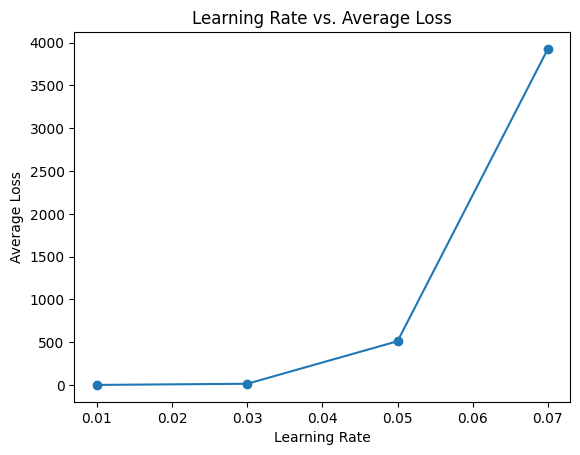

In [ ]:
# Train with different lrs
batch_size = 1024
epochs = 2
average_losses = []
learning_rate= []
for i in range(4):
  model = Sequential()
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(4,)))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(1))
  model.compile(optimizer=Adam(), loss='mean_squared_error')
  K.set_value(model.optimizer.learning_rate, 0.01+i*0.02)
  learning_rate.append(0.01+i*0.02)
  with tf.device('/GPU:0'):
      history = model.fit(
          train_df[['Sk', 'r', 'T', 'sigma']],
          train_df['Price'],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1
      )
  average_losses.append(
      np.average(history.history['loss'])
  )

import matplotlib.pyplot as plt
import numpy as np
plt.plot(learning_rate, average_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Average Loss')
plt.title('Learning Rate vs. Average Loss')
plt.show()

Epoch 1/2
110/110 [==============================] - 10s 78ms/step - loss: 0.0243
Epoch 2/2
3516/3516 [==============================] - 11s 3ms/step
Epoch 1/2
220/220 [==============================] - 15s 65ms/step - loss: 0.0161
Epoch 2/2
7032/7032 [==============================] - 18s 2ms/step
Epoch 1/2
330/330 [==============================] - 22s 65ms/step - loss: 0.0090
Epoch 2/2
10547/10547 [==============================] - 28s 3ms/step


Text(0, 0.5, 'R2(%)')

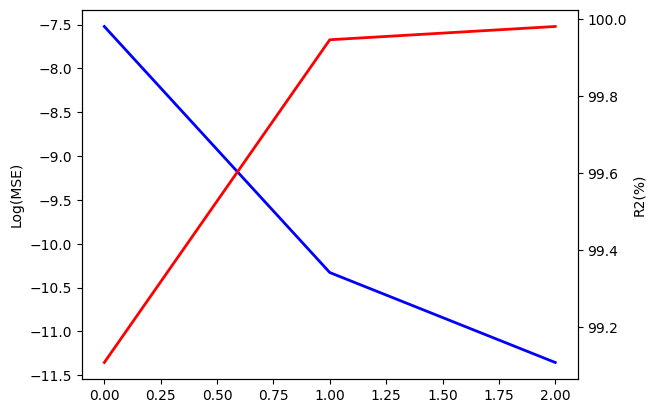

In [ ]:
# Train with differnt dataset size
batch_size = 1024
epochs = 2
R2s = []
mses = []
x=[]
for i in range(3):
  model = Sequential()
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(4,)))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
  model.add(Dense(1))
  model.compile(optimizer=Adam(), loss='mean_squared_error')
  K.set_value(model.optimizer.learning_rate, 0.0001)
  with tf.device('/GPU:0'):
      history = model.fit(
          train_df[['Sk', 'r', 'T', 'sigma']][:int((i+1)/8*len(train_df))],
          train_df['Price'][:int((i+1)/8*len(train_df))],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1
      )
  train_predicteds = model.predict(train_df[['Sk', 'r', 'T', 'sigma']][:int((i+1)/8*len(train_df))])
  _metrics = calc_metrics(train_df['Price'][:int((i+1)/8*len(train_df))], train_predicteds)
  R2s.append(_metrics['r2']*100)
  mses.append(np.log(_metrics['mse']))
  x.append(i)
fig, ax1 = plt.subplots()

ax1.plot(x, mses, lw=2, color="blue")
ax1.set_ylabel(r"Log(MSE)", fontsize=10)

ax2 = ax1.twinx()
ax2.plot(x, R2s, lw=2, color="red")
ax2.set_ylabel(r"R2(%)", fontsize=10 )

100000
100000


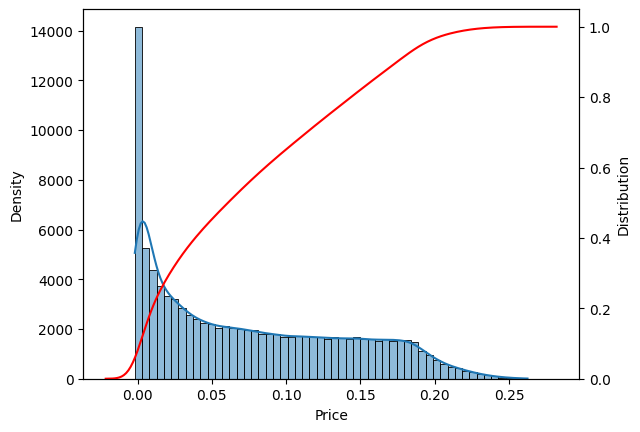

In [ ]:
print(len(test_df['sigma']))
print(len(wide_test_predictions))
error=geek.subtract(test_df['Price'], wide_test_predictions)

# Plotting histogram with KDE
sb.histplot(error, kde=True, edgecolor='black')
plt.ylabel("Density")


# Plotting cumulative KDE
ax2 = plt.twinx()
sb.kdeplot(error, cumulative=True, color="red", ax=ax2)
ax2.set_ylabel("Distribution", fontsize=10)

plt.show()

<div id="Step 4: Black-Scholes Implicit Volatility ANN">
    <h1>Step 4: Black-Scholes Implicit Volatility ANN</h1>
</div>

<h3>Part 1 –The resulting input is then given by {V/K, S0/K,r, τ} </h3>

In [ ]:
# Train the model on the GPU
model = Sequential()
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(4,)))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
batch_size = 1024
epochs = 10
with tf.device('/GPU:0'):
    history = model.fit(
        train_df[['Sk', 'r', 'T', 'Price']],
        train_df['sigma'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

Epoch 1/10
879/879 [==============================] - 58s 64ms/step - loss: 0.0091
Epoch 2/10
879/879 [==============================] - 57s 65ms/step - loss: 0.0018
Epoch 3/10
879/879 [==============================] - 56s 64ms/step - loss: 0.0015
Epoch 4/10
879/879 [==============================] - 56s 63ms/step - loss: 0.0014
Epoch 5/10
879/879 [==============================] - 55s 63ms/step - loss: 0.0013
Epoch 6/10
879/879 [==============================] - 57s 65ms/step - loss: 0.0012
Epoch 7/10
879/879 [==============================] - 56s 64ms/step - loss: 0.0012
Epoch 8/10
879/879 [==============================] - 55s 63ms/step - loss: 0.0011
Epoch 9/10
879/879 [==============================] - 57s 65ms/step - loss: 0.0011
Epoch 10/10
879/879 [==============================] - 58s 66ms/step - loss: 0.0011


In [ ]:
# Evaluate the trained model on the test sets on the GPU

with tf.device('/GPU:0'):
    wide_test_loss = model.evaluate(
        test_df[['Sk', 'r', 'T', 'Price']],
        test_df['sigma'],
        verbose=0
    )

wide_test_predictions = model.predict(test_df[['Sk', 'r', 'T', 'Price']])
res= calc_metrics(test_df['sigma'], wide_test_predictions)
print(res)

3125/3125 [==============================] - 7s 2ms/step
{'mse': 0.0012293477194626039, 'mae': 0.02291394119952112, 'r2': 0.9809931881803292}


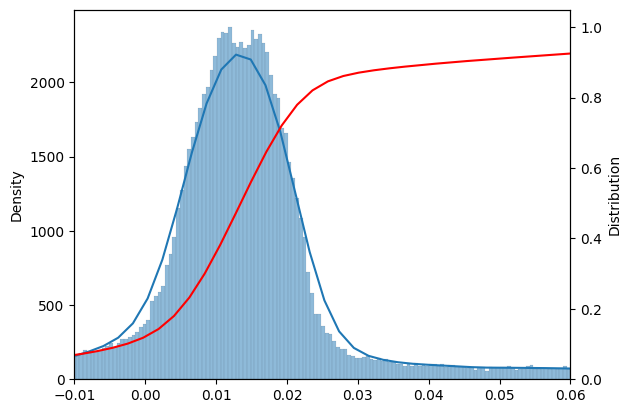

In [ ]:
error = []
for myindex, sigma in enumerate(test_df['sigma']):
  error.append(sigma-wide_test_predictions[myindex][0])
sb.histplot(error, kde=True, edgecolor='black')
plt.ylabel("Density")


# Plotting cumulative KDE
ax2 = plt.twinx()
sb.kdeplot(error, cumulative=True, color="red", ax=ax2)
ax2.set_ylabel("Distribution", fontsize=10)

plt.xlim(-0.01, 0.06)
plt.show()

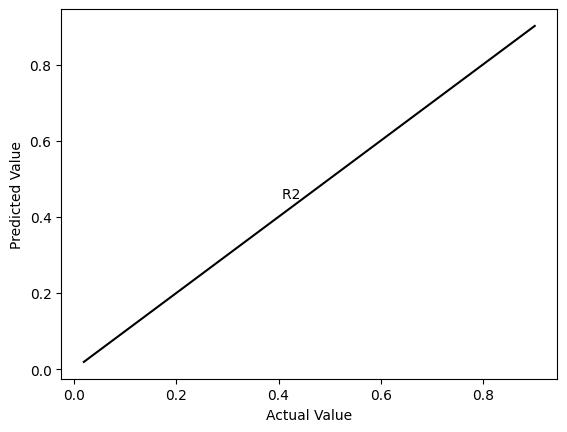

In [ ]:
plt.plot([min(test_df['sigma']), max(test_df['sigma'])], [min(wide_test_predictions), max(wide_test_predictions)], 'k-',  label='R2')
# Calculate the midpoint coordinates of the line
x_mid = (min(test_df['sigma']) + max(test_df['sigma'])) / 2
y_mid = (min(wide_test_predictions) + max(wide_test_predictions)) / 2

# Add the 'R2' label at the midpoint
plt.text(x_mid, y_mid, 'R2  ', ha='right', va='center')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()


<h3>Part 2 – $$ Vhat = V − MAX(S − Ke^{−rτ}, 0) $$ </h3>
where Vhat is the option time value.
<br>The proposed approach to overcome approximation issues is to reduce the gradient’s steepness by furthermore working under a log-transformation of the option value. The resulting input is then given by {log (Vhat/K), S0/K,r, τ}. The adapted gradient approach increases the prediction accuracy significantly

In [ ]:
warnings.filterwarnings('ignore')

Vhat=np.log(option_prices-np.maximum(Sk -  np.exp(-r * T), 0))

df2= pd.DataFrame({'Sk': Sk, 'r': r, 'T': T, 'sigma': sigma, 'Price': Vhat})
df2.replace([-np.inf, -np.inf], np.nan, inplace=True)
df2.dropna(inplace=True)

# Split the dataset into train and testnan sets
train_df2, test_df2 = train_test_split(df2, test_size=0.1, random_state=42)


In [ ]:
# Train the model on the GPU
model = Sequential()
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(4,)))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
batch_size = 1024
epochs = 10
with tf.device('/GPU:0'):
    history = model.fit(
        train_df2[['Sk', 'r', 'T', 'Price']],
        train_df2['sigma'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

Epoch 1/10
868/868 [==============================] - 57s 65ms/step - loss: 0.0254
Epoch 2/10
868/868 [==============================] - 54s 62ms/step - loss: 0.0011
Epoch 3/10
868/868 [==============================] - 56s 64ms/step - loss: 7.7130e-08
Epoch 4/10
868/868 [==============================] - 55s 63ms/step - loss: 6.4656e-08
Epoch 5/10
868/868 [==============================] - 54s 63ms/step - loss: 3.6444e-05
Epoch 6/10
868/868 [==============================] - 58s 67ms/step - loss: 3.6026e-06
Epoch 7/10
868/868 [==============================] - 57s 65ms/step - loss: 4.5707e-06
Epoch 8/10
868/868 [==============================] - 55s 63ms/step - loss: 6.8074e-06
Epoch 9/10
868/868 [==============================] - 55s 63ms/step - loss: 2.3071e-05
Epoch 10/10
868/868 [==============================] - 57s 66ms/step - loss: 6.3326e-09


In [ ]:
# Evaluate the trained model on the test sets on the GPU

with tf.device('/GPU:0'):
    wide_test_loss = model.evaluate(
        test_df2[['Sk', 'r', 'T', 'Price']],
        test_df2['sigma'],
        verbose=0
    )

wide_test_predictions = model.predict(test_df2[['Sk', 'r', 'T', 'Price']])

res= calc_metrics(test_df2['sigma'], wide_test_predictions)
print(res)

3084/3084 [==============================] - 8s 3ms/step
{'mse': 4.210007605292294e-09, 'mae': 4.757111173965783e-05, 'r2': -2.428845473707435e+24}
